In [1]:
import timm
import numpy as np
import torch
import matplotlib.pyplot as plt
import transformers
import pandas as pd
import seaborn as sns
from transformers import pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from PIL import Image

c:\Users\seung\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\seung\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install sentencepiece


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install datasets evaluate transformers[sentencepiece]


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!python generate_list.py --name weather_test --path ./dataset

In [ ]:
# Read Images
image_list = list()
for path in data['path']:
    image = Image.open(path)
    image_list.append(image)
len(image_list)

In [16]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
label = data['class']
num_class = len(data['class'].unique())
names = ['fire','fogsmog', 'lightning', 'rain', 'sandstorm','snow']
data['name'] = [names[i] for i in data['class']]

C:\Users\seung\AppData\Local\Temp\ipykernel_54584\228420673.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_224= pipeline(task="image-feature-extraction", model_name="vit_base_patch16_224", device=DEVICE, pool=True)

In [ ]:
#Start Inference
outputs = pipe_224(image_list)
#Change shapes 
np_output = np.array(outputs)
reshaped_output = np_output.reshape((np_output.shape[0],-1))
reshaped_output.shape
np.savetxt('./output.txt', reshaped_output)

In [8]:
loaded_vector = np.loadtxt("./output_vit_224.txt")
loaded_vector.shape

(4067, 768)

## Spectral Clustering


In [10]:
from sklearn.cluster import SpectralClustering

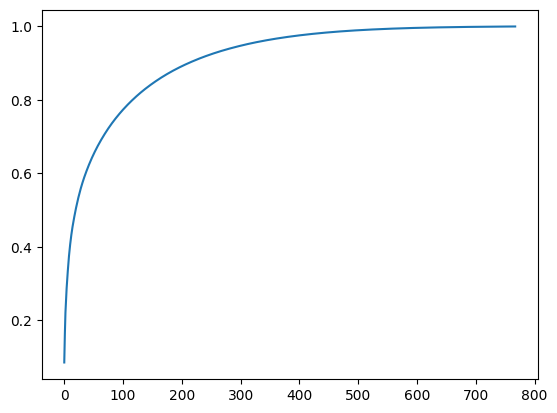

In [18]:
pca = PCA()
pca.fit(loaded_vector)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [109]:
pca = PCA(n_components=300)
ex1 = pca.fit_transform(loaded_vector)
ex1.shape

(4067, 300)

## Kmeans

c:\Users\seung\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

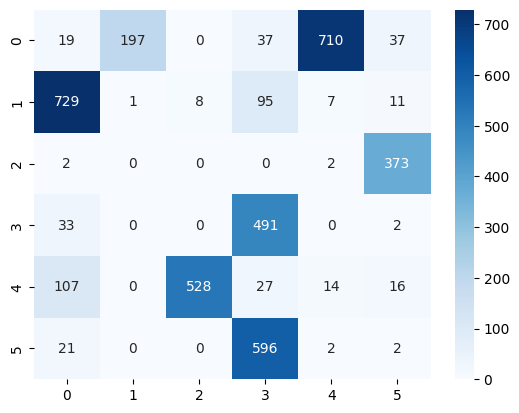

In [110]:
kmeans = KMeans(n_clusters = 6)
y_kmean = kmeans.fit_predict(ex1)
conf_0_matrix = confusion_matrix(label, y_kmean)
sns.heatmap(conf_0_matrix, annot=True, fmt="d", cmap="Blues")

## Spectral Clustering

Text(50.722222222222214, 0.5, 'class')

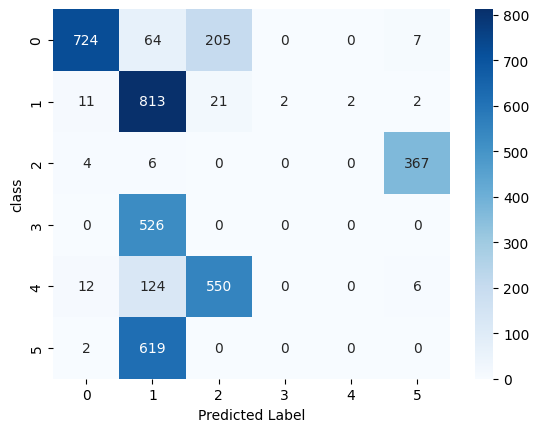

In [44]:
spectral = SpectralClustering(n_clusters=6, affinity='rbf', random_state=10)
y_pred = spectral.fit_predict(ex1)
conf_matrix = confusion_matrix(label, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')

In [12]:
y_pred

array([5, 5, 5, ..., 0, 0, 0])

## DBSCAN 

In [45]:
from sklearn.cluster import DBSCAN

In [181]:
pca = PCA(n_components=700)
ex1 = pca.fit_transform(loaded_vector)
ex1.shape

(4067, 700)

In [182]:
kmeans.inertia_

328426.6752065522

In [ ]:
def dbscan_finder(range_max:int, input_vector):
    target_eps = []
    for i in range(1,range_max):
        i = (float)(i)
        y_dbscan = DBSCAN(eps = i, min_samples = 350).fit_predict(input_vector)
        if len(np.unique(y_dbscan)) >=3:
            target_eps.append(i)
    return target_eps

res = dbscan_finder(100,ex1)

In [196]:
y_dbscan = DBSCAN(eps=11,min_samples=350).fit_predict(ex1)
np.unique(y_dbscan)

array([-1,  0,  1], dtype=int64)

Text(50.722222222222214, 0.5, 'class')

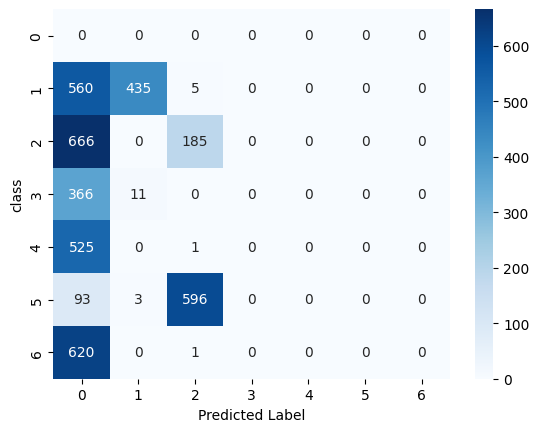

In [194]:
conf_matrix = confusion_matrix(label, y_dbscan)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')

## Bisecting Kmeans

In [197]:
pca = PCA(n_components=700)
ex1 = pca.fit_transform(loaded_vector)
ex1.shape

(4067, 700)

In [209]:
from sklearn.cluster import BisectingKMeans

BK = BisectingKMeans(n_clusters = 6, max_iter=100)
BK_y = BK.fit_predict(ex1)

Text(50.722222222222214, 0.5, 'class')

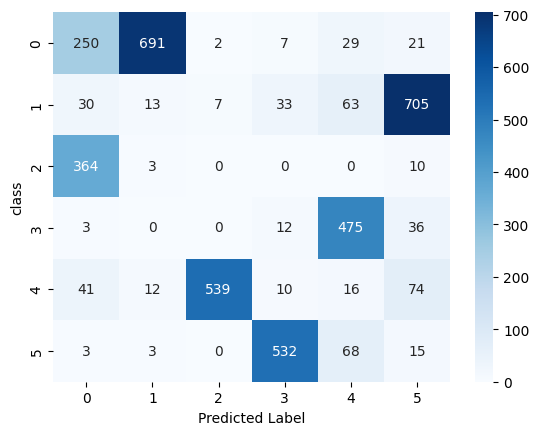

In [210]:
conf_matrix = confusion_matrix(label, BK_y)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')

In [211]:
cp = BK.cluster_centers_

In [212]:
cp.shape

(6, 700)

### Compatibility test with Bisect kmean <-> kmean

Text(50.722222222222214, 0.5, 'class')

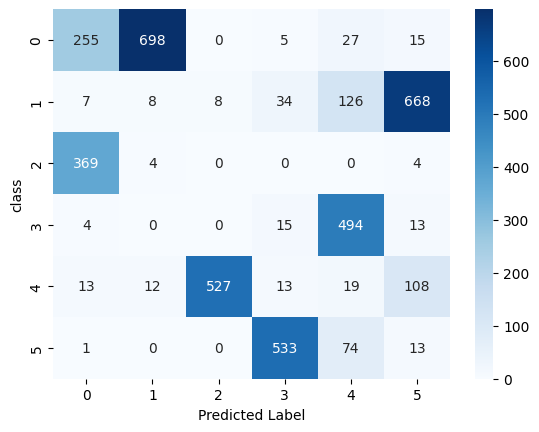

In [213]:
test_kmeans = KMeans(n_clusters=6, init=cp, n_init=1)
y_kmean = test_kmeans.fit_predict(ex1)
conf_matrix = confusion_matrix(label, y_kmean)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')

In [9]:
pca = PCA(n_components=700)
ex1 = pca.fit_transform(loaded_vector)
ex1.shape

(4067, 700)

## BIRCH

In [10]:
from sklearn.cluster import Birch

In [13]:
pca = PCA(n_components=700)
ex1 = pca.fit_transform(loaded_vector)
ex1.shape

(4067, 700)

In [24]:
B_cluster = Birch(n_clusters = 6, threshold=0.1, branching_factor=50 )
b_y_pred = B_cluster.fit_predict(ex1)

In [32]:
B_cluster.get_feature_names_out()

array(['birch0', 'birch1', 'birch2', ..., 'birch4008', 'birch4009',
       'birch4010'], dtype=object)

Text(50.722222222222214, 0.5, 'class')

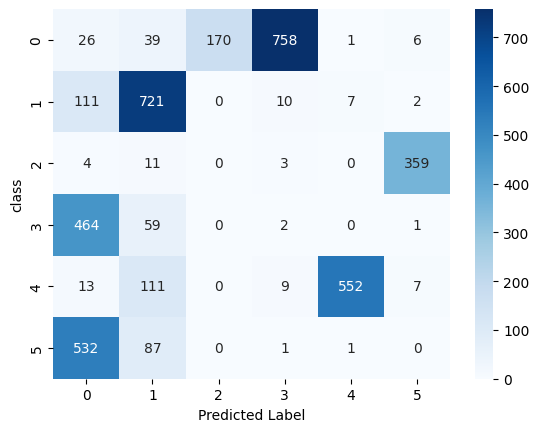

In [25]:
conf_matrix = confusion_matrix(label, b_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('class')